In [59]:
import numpy as np
import matplotlib.pyplot as plt
import random
import corner

arr=np.load('test_line.npy')

In [60]:
z= arr[2] #errores asociados a y
va = np.var(arr[1]) #varianza de y
sigma = 0.6
sd=np.std(arr[0])

In [61]:
A = np.vstack([arr[0], np.ones(len(arr[0]))]).T
p, b = np.linalg.lstsq(A, arr[1], rcond=None)[0]
# El valor de la pendiente de este ajuste es p y b su ordenada al origen
p, b, va, sigma, sd

(30.762307652444512,
 199.34272404405507,
 425.04708009743285,
 0.6,
 0.6172133998483675)

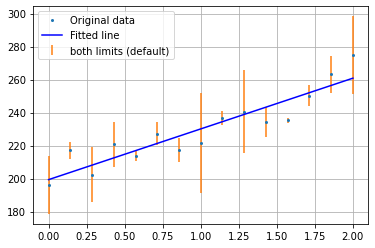

In [62]:
# Graficamos el ajuste lineal
plt.plot(arr[0], arr[1], 'o', label='Original data', markersize=2)
plt.plot(arr[0], p*arr[0] + b, 'b', label='Fitted line')
plt.errorbar(arr[0], arr[1],yerr= arr[2],ls='',label='both limits (default)')
plt.grid()
plt.legend()
plt.show()

### Añadir la opción de tener multiples caminadores en el MCMC
### Añadir grafica de triangulo
### Añadir analisis cuantitativo de las cadenas
### Añadir diagnostico de Gelman-Rubin
# $s^{2}_{i}=\frac{1}{n-1}\sum_{t=1}^{n}(X_{it}-\bar{X_{i}})^{2}$
# $s^{2}=\frac{1}{m}\sum_{i=1}^{m}s_{i}^{2}$
# $\frac{B}{n}=\frac{1}{m-1}\sum_{i=1}^{m}(\bar{X}_{i}-\hat{\mu})^{2}$
# $\hat{\sigma}=\frac{n-1}{n}s^{2}+\frac{B}{n}$
# $\hat{R}=\sqrt{\frac{\hat{\sigma}^{2}}{s^{2}}}$
#### $\bar{X}_{i}$ media por cadena (para un parametro dado)
#### $s_{i}$ varianza por cadena
#### $n$ samples in a chain
#### $m$ chains
#### $\mu$ overall mean fro a given parameter
#### si $\hat{R}\leq\delta$ para algun $\delta$ la cadena puede tener convergencia. 





In [63]:
# Definimos el Prior Plano
def log_prior(theta):
    alpha, beta = theta
    if -300 < beta < 300 and 0.0 < alpha < 40 : #elegimos el prior en este rango
        return 1.0
    else:
        return np.inf #Diverge 

# Definamos el Likelihood para modelo lineal y=b+mx
def log_likelihood(theta, x, y):
    alpha, beta = theta # Parametros 
    y_model = alpha + beta * x #Modelo Lineal 
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

# Definamos el Logaritmos del Posterior 
def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

In [79]:
def muestreo( x, y, n, m): #n,  número de muestreos;
    #m :número de caminadores
    print(str(m)+' caminadores')
    s=np.zeros(m*2).reshape([m,2]) #construimos una matriz 2 x m 
    #con ceros con m como el numero de caminadores """
    for j in range(m): 
        
        New=np.zeros(2) #Definimos una matriz con ceros para
        #ingresar en ella valores posteriores
        
        theta=[random.uniform(20,40),random.uniform(180, 220)] #elegimos un valor inicial 
        #para los paramatros, esto para cada valor de j en el rango de m
        
        theta_1=[theta] # colocamos estos valores aleatorios de los parametros en una array 1-D
        
        contador=0 # Contador de aceptaciones
        
        for i in range(n): #comenzamos el ciclo para n muestreos
            
            # Proponemos de manera aleatoria nuevos valores para los parametros alpha y beta
            New[0]=  np.random.normal(theta[0], 0.6) # con media dada por theta[0] y sigma 2.5
            New[1]=  np.random.normal(theta[1], 0.6) # con media dada por theta[1] y sigma 2.5
           
            #calculamos los log_posterior para los valores theta y New
            p_old = log_posterior(theta,x,y)
            p_new = log_posterior(New,x,y)
                       
            #si es mayor el posterior con los parametros en New lo aceptamos
            #y lo guardamos
            if p_new>p_old:
                theta= np.array(New) #Guardamos los valores aceotados en un array
                contador+=1
            #Si el posterior con los parametros New es menor que el 
            #posterior con los parametros theta, elegiremos un numero aleatorio 
            #entre o y 1 y lo compararemos con el cociente P_New/P_Old, si este 
            #cociente es mayor que ese numero, aceptamos este nuevo arreglo de 
            #parametros
            else:
                cociente =  p_old/ p_new
                numero_rnd = np.random.rand() #Numero alaetorio entre cero y uno
                
                if numero_rnd > cociente:
                    theta= np.array(New)
                    contador+=1
            
            theta_1=np.append(theta_1,[theta],axis=0) # Guardamos los valores viejos y 
            #nuevos de los parametros en un nuevo array
            
        if j==0: # Para el caminador inicial
           muestreos=np.array(theta_1)
           #calculamos las desviaciones estandar de los parametros en muestreos para el caminador incial j=0
           # y los guardamos en s.
           s[j,0]=np.var(muestreos[:,0], ddof=1)#Means Delta Degrees of Freedom. The divisor used in calculations is N - ddof, where N represents the number of elements. By default ddof is zero.
           s[j,1]=np.var(muestreos[:,1], ddof=1)
           # calculamos las medias de los parametros de los parametros en muestreos para el caminador j=0 y los guardamos en s. 
           mean=np.array([np.mean(muestreos[:,0]),np.mean(muestreos[:,1])])
            
           print('beta de caminador '+str(j+1)+':'+str(mean[1]))
           print('alpha de caminador '+str(j+1)+':'+str(mean[0]))
           plt.title('Parámetros')
           plt.ylabel('alpha')
           plt.xlabel('beta')
           plt.scatter(muestreos[:,0],muestreos[:,1], marker='.', c='b')
           plt.grid()
           plt.show()
           plt.clf();


            

        else:
            muestreos2=np.array(theta_1)
            #calculamos las desviaciones estandar de los parametros en muestreos2 para el caminador incial j distinto de 0
            # y los guardamos en s.
            s[j,0]=np.var(muestreos2[:,0], ddof=1)
            s[j,1]=np.var(muestreos2[:,1], ddof=1)
            # calculamos las medias de los parametros en muestreos para el caminador j distinto de 0 y los guardamos en s.
            mean=np.vstack([mean, [np.mean(muestreos2[:,0]),np.mean(muestreos2[:,1])]])
            print('beta de caminador '+str(j+1)+':'+str(mean[j,1]))
            print('alpha de caminador '+str(j+1)+':'+str(mean[j,0]))
            muestreos = np.vstack([muestreos, muestreos2]) #Stack arrays in sequence vertically (row wise).
            plt.title('Parámetros')
            plt.ylabel('alpha')
            plt.xlabel('beta')
            plt.scatter(muestreos2[:,0],muestreos2[:,1], marker='.', c='b')
            plt.grid()
            plt.show()
            plt.clf();
        #calculamos
        tasa_acept=contador/n
        print('tasa de aceptacion'+str(j+1)+':'+str(tasa_acept))
        print('\n')
    
    R=GelmanRubin(s,m,mean,muestreos,n)
    print('R'+str(R))

    return muestreos,tasa_acept


In [80]:
# Definamos las funciones para Gelman-Rubin
def GelmanRubin(s,m,mean,muestreos,n):
    # Recordemos que s contiene las desviaciones estandar para los parametros alpha por cada cadena
    # Recordemos tambien que mean contiene los valores medios de los parametros por cada cadema
    if m==1:
        return 0
    else:
        S=[np.square(s[:,0]).sum()/m,np.square(s[:,1]).sum()/m]
        Bn=[np.var(mean[:,0], ddof=1),np.var(mean[:,1], ddof=1)]
        Sig_hat=[(n-1)*S[0]/n  +Bn[0],(n-1)*S[1]/n  +Bn[1]]
        R=np.sqrt(np.divide(Sig_hat,S))
    return R

4 caminadores


<ipython-input-79-2c8681da4ea9>:39: RuntimeWarning: invalid value encountered in double_scalars
  cociente =  p_old/ p_new


beta de caminador 1:147.86816517139982
alpha de caminador 1:40.36549905343988


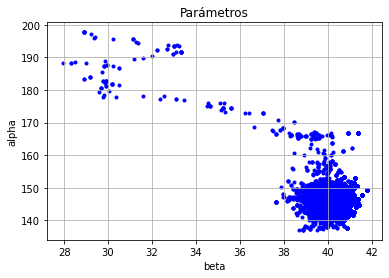

tasa de aceptacion1:0.2616


beta de caminador 2:151.28588755221588
alpha de caminador 2:40.354982346094125


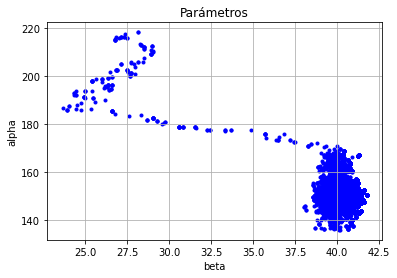

tasa de aceptacion2:0.2244


beta de caminador 3:146.85756767452008
alpha de caminador 3:40.42248609124908


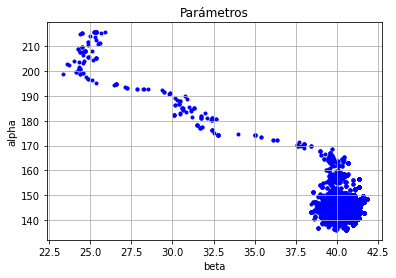

tasa de aceptacion3:0.2088


beta de caminador 4:145.77560933711683
alpha de caminador 4:40.4876075957984


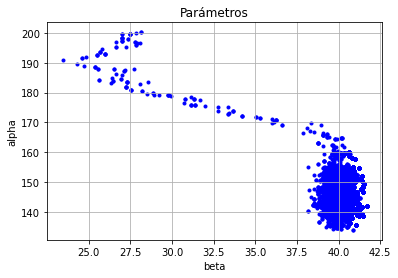

tasa de aceptacion4:0.2266


R[1.00016472 1.00096553]
beta promedio: 147.94680743381315
alpha promedio: 40.40764377164537


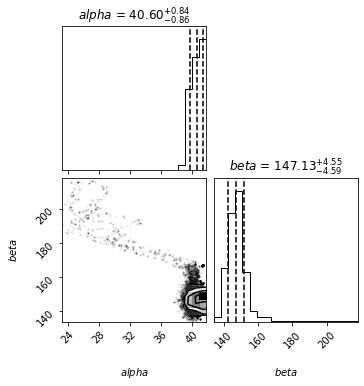

<Figure size 432x288 with 0 Axes>

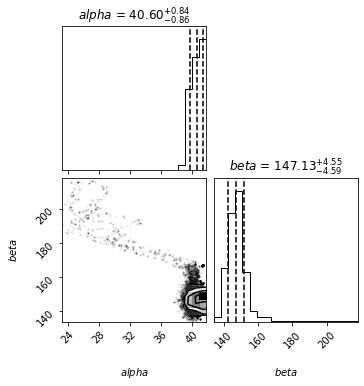

In [81]:
#calculamos los parámetros y la tasa de aceptación  
caminadores,tasa_acept=muestreo(arr[0], arr[1], 10000, 4)
print('beta promedio: '+str(np.mean(caminadores[:,1])))
print('alpha promedio: '+str(np.mean(caminadores[:,0])))
#graficamos los resultados de los parámetros 
figure = corner.corner(caminadores, labels=[r"$alpha$", r"$beta$"],quantiles=[0.16, 0.5, 0.84],show_titles=True,hist_kwargs={'density':True}, title_kwargs={"fontsize": 12},sooth=True);
figure